# Scenario Discovery

This file analyzes results from the Open Exploration using PRIM and Dimensional Stacking.
These methods help identify input conditions that lead to specific outcome ranges, supporting decision-making under uncertainty.

## 1. Apply PRIM

**1.** Import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

**2.** Import results from Open Exploration



In [2]:
from ema_workbench import load_results

# Load the results that were generated in the open exploration step
results = load_results('dike_open_exploration_results.tar.gz')
experiments, outcomes = results

# Metadata columns to exclude
columns_to_drop = ['scenario', 'policy', 'model']

# Create a cleaned dataframe with only experimental variables
cleaned_experiments = experiments.drop(columns=columns_to_drop)

In [3]:
# See cleaned experiments
cleaned_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat
0,27,305.687148,1.5,0.027832,68.359127,1.5,0.152884,167.261300,10.0,0.345284,...,9,6,7,2,9,1,6,6,5,1
1,49,184.935658,1.5,0.144667,38.274603,1.5,0.807387,71.791046,1.0,0.262927,...,9,6,7,2,9,1,6,6,5,1
2,13,164.819438,10.0,0.767065,124.757598,1.0,0.255756,164.351654,1.0,0.596933,...,9,6,7,2,9,1,6,6,5,1
3,124,182.023088,1.0,0.595303,151.500057,1.5,0.644332,102.804731,1.0,0.680736,...,9,6,7,2,9,1,6,6,5,1
4,118,274.075171,1.0,0.766450,249.129695,1.5,0.156813,296.012131,1.0,0.281304,...,9,6,7,2,9,1,6,6,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274995,65,133.888803,10.0,0.290900,346.764144,1.0,0.144683,131.921561,1.0,0.890272,...,4,2,3,4,5,8,0,0,4,2
274996,123,88.754242,10.0,0.515894,320.261164,10.0,0.603532,163.144599,1.0,0.691465,...,4,2,3,4,5,8,0,0,4,2
274997,20,177.859906,1.5,0.670260,138.756215,10.0,0.351170,39.689428,1.0,0.303821,...,4,2,3,4,5,8,0,0,4,2
274998,32,201.286779,1.5,0.706167,178.042102,1.0,0.326051,342.924122,10.0,0.774295,...,4,2,3,4,5,8,0,0,4,2


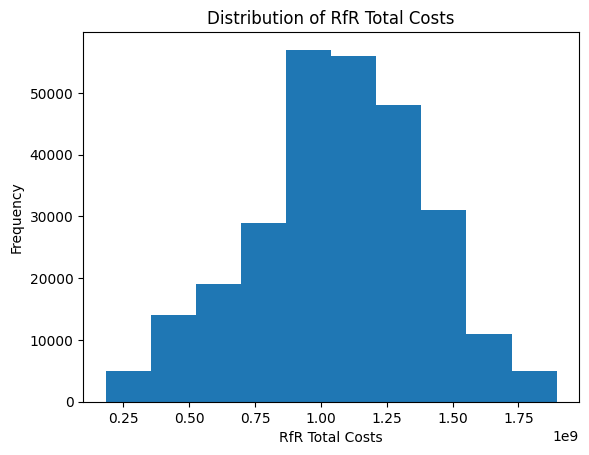

In [4]:
# Plot a histogram of the Room for the River (RfR) total costs
y_rfr = outcomes['RfR Total Costs']
plt.hist(y_rfr)
plt.xlabel("RfR Total Costs")
plt.ylabel("Frequency")
plt.title("Distribution of RfR Total Costs")
plt.show()

**3.** Apply scenario discovery


#### 1. RFR Total Cost

'RfR Total Costs': 125000 of 275000 are True.


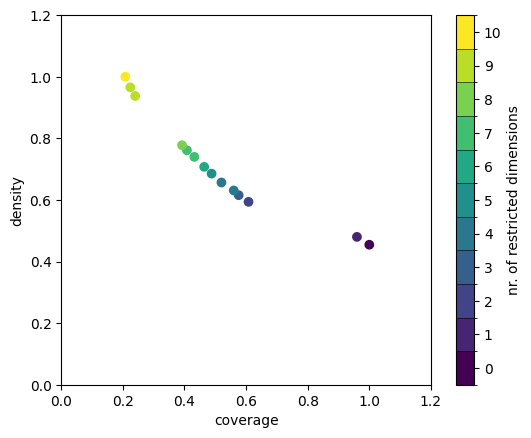

In [5]:
from ema_workbench.analysis import prim

# Set thresholds to define a desirable range for RfR Total Costs
threshold_rfr_min = 1000000000
threshold_rfr_max = 1400000000

# Look for outcomes that fall within the specified range
y_rfr = (outcomes['RfR Total Costs'] >= threshold_rfr_min) & (outcomes['RfR Total Costs'] <= threshold_rfr_max)

# Copy experimental input data and run PRIM
x_rfr = cleaned_experiments.copy()
prim_alg_rfr = prim.Prim(x_rfr, y_rfr, threshold=0.8)
box_rfr = prim_alg_rfr.find_box()

# Print number of cases within the defined range and show trade-off plot
print(f"'RfR Total Costs': {y_rfr.sum()} of {len(y_rfr)} are True.")
box_rfr.show_tradeoff()
plt.show()

coverage        0.408000
density         0.761194
id              9.000000
k           51000.000000
mass            0.243636
mean            0.761194
n           67000.000000
res_dim         7.000000
Name: 9, dtype: float64

                   box 9                                    
                     min   max       qp value       qp value
A.2_DikeIncrease 1   0.0   9.0            NaN  1.860894e-178
A.4_DikeIncrease 2   0.0   9.0            NaN  1.860894e-178
A.3_DikeIncrease 2   0.0   9.0            NaN  5.890635e-129
1_RfR 1              1.0   1.0   0.000000e+00            NaN
A.3_DikeIncrease 0   2.0  10.0  1.907042e-141            NaN
A.2_DikeIncrease 0   1.0  10.0   1.823887e-95            NaN
A.1_DikeIncrease 0   1.0   9.0   1.100533e-37  8.140448e-220



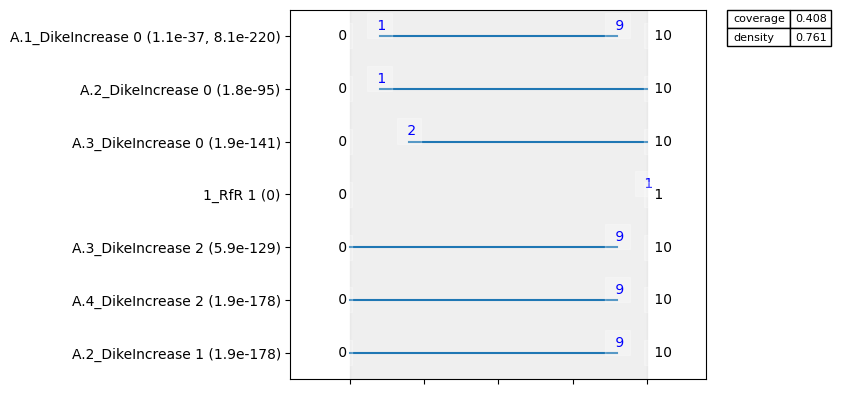

In [6]:
# Inspect box
box_rfr.inspect(9)
box_rfr.inspect(9, style='graph')
plt.show()

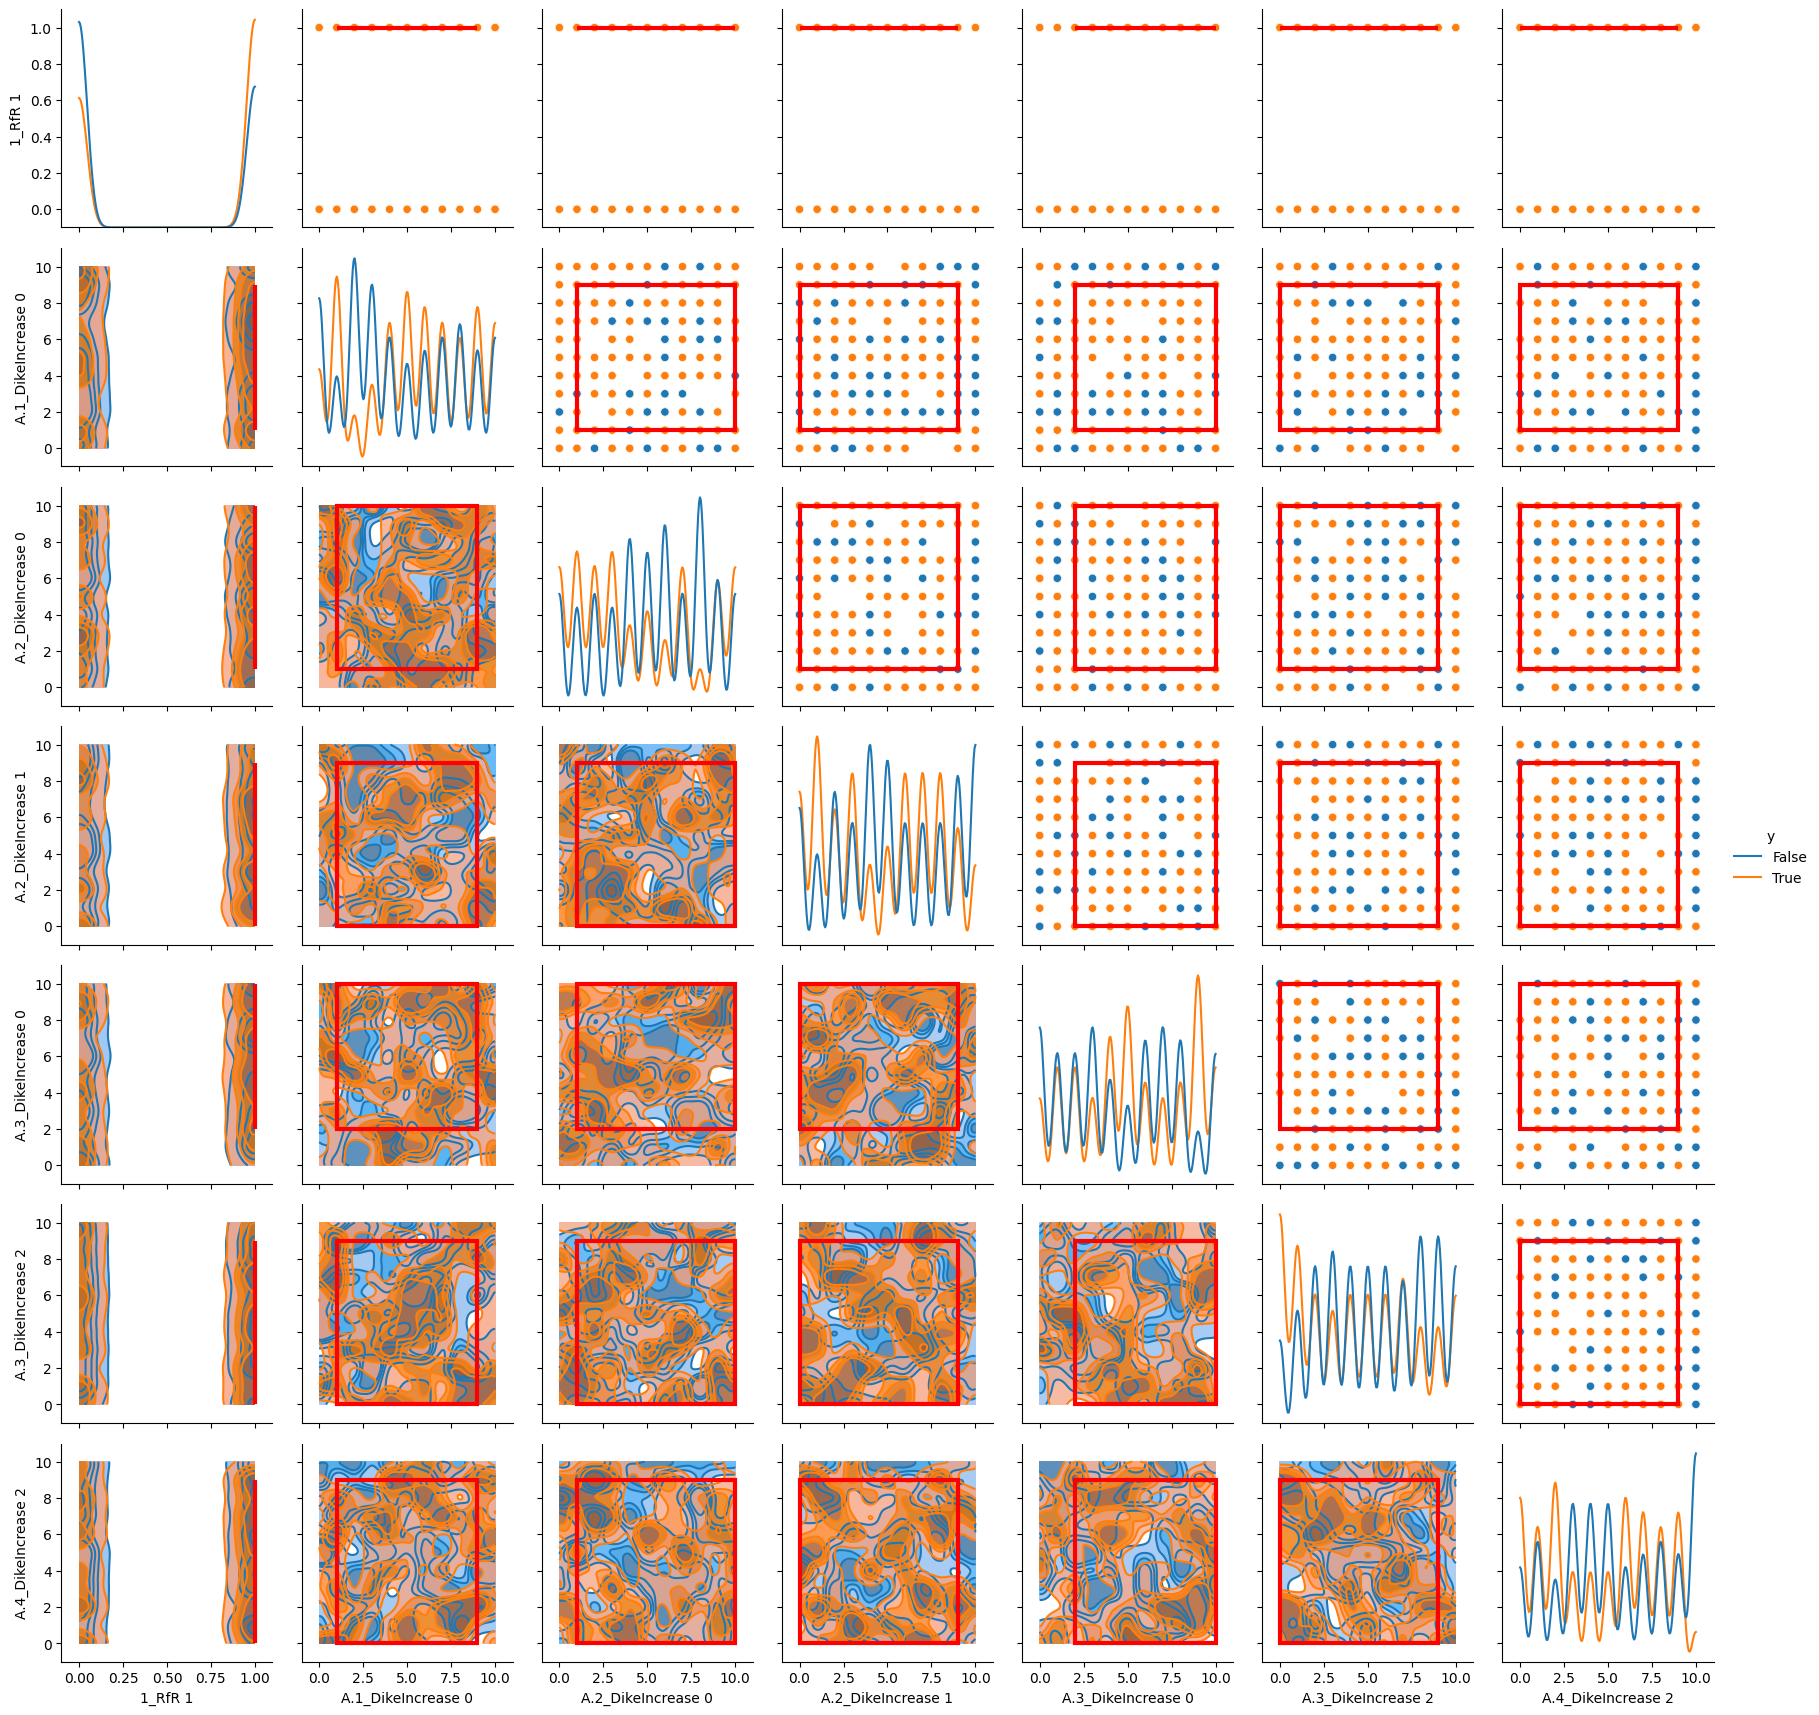

In [7]:
# Show scenario discovery
box_rfr.show_pairs_scatter(9)
plt.show()

### 2. Expected Annual Damage

'Expected Annual Damage': 180565 of 275000 are True.


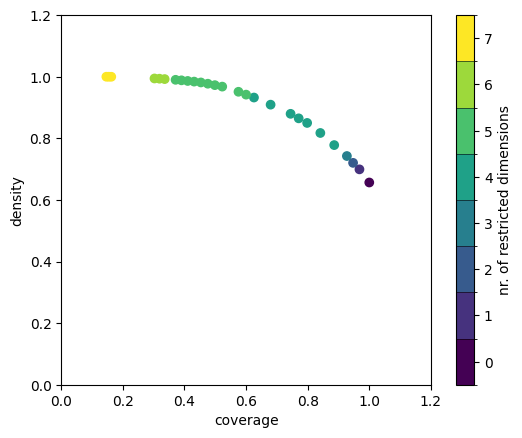

In [8]:
# Look for outcomes that fall within the specified range
threshold_ead = 5000000
y_ead = outcomes['Expected Annual Damage'] <= threshold_ead

# Copy experimental input data and run PRIM
x_ead = cleaned_experiments.copy()
prim_alg_ead = prim.Prim(x_ead, y_ead, threshold=0.8)
box_ead = prim_alg_ead.find_box()

# Print number of cases within the defined range and show trade-off plot
print(f"'Expected Annual Damage': {y_ead.sum()} of {len(y_ead)} are True.")
box_ead.show_tradeoff()
plt.show()

coverage         0.679617
density          0.909283
id               9.000000
k           122715.000000
mass             0.490756
mean             0.909283
n           134958.000000
res_dim          4.000000
Name: 9, dtype: float64

                       box 9                             
                         min        max qp value qp value
A.2_pfail           0.095847   0.999885      0.0      NaN
A.3_pfail           0.094081   0.999163      0.0      NaN
A.2_DikeIncrease 0  3.000000  10.000000      0.0      NaN
A.3_DikeIncrease 0  2.000000  10.000000      0.0      NaN



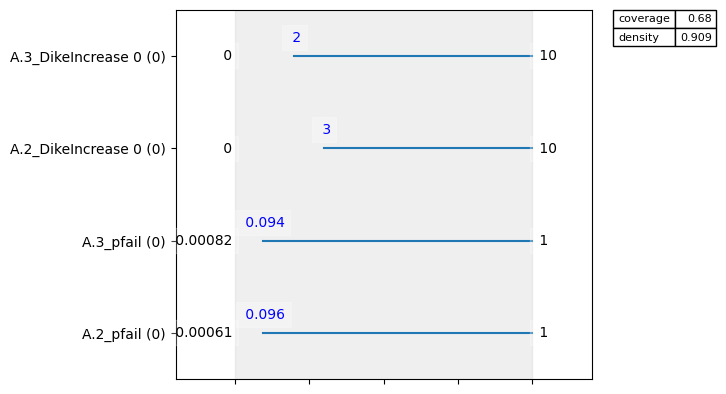

In [9]:
# Inspect box
box_ead.inspect(9)
box_ead.inspect(9,style='graph')
plt.show()

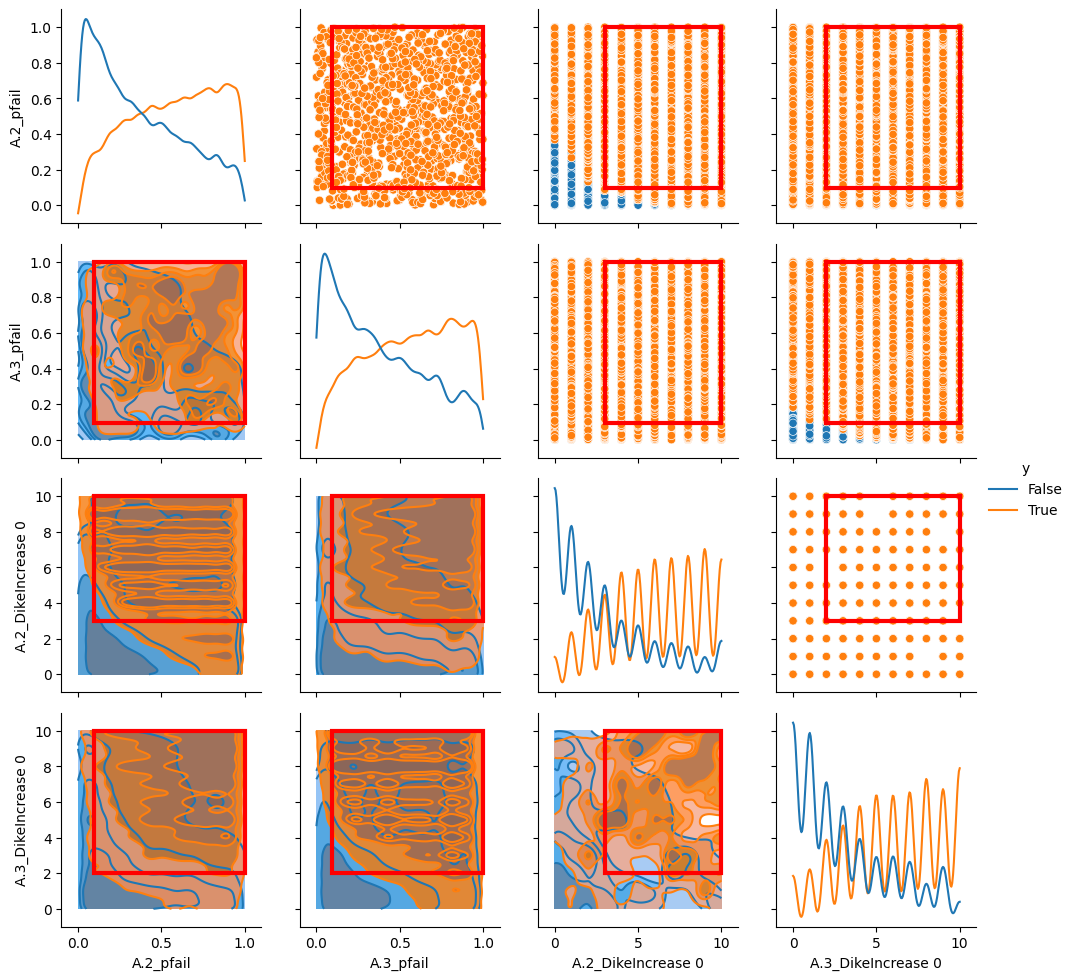

In [10]:
# Show scenario discovery
box_ead.show_pairs_scatter(9)
plt.show()

### 3. 'Dike Investment Costs'

'Dike Investment Costs': 222000 of 275000 are True.


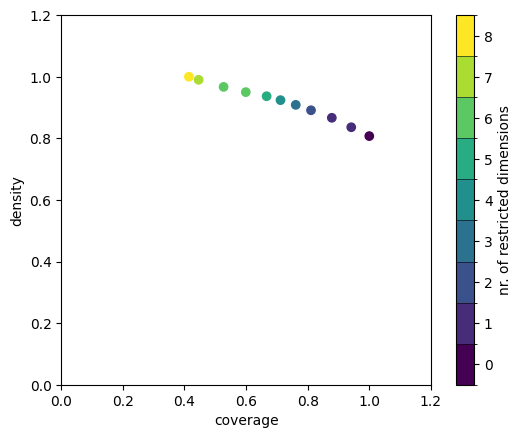

In [11]:
# Look for outcomes that fall within the specified range
threshold_dike_inv = 600000000
y_dike_inv = (outcomes['Dike Investment Costs'] <= threshold_dike_inv).astype(bool)

# Copy experimental input data and run PRIM
x_dike_inv = cleaned_experiments.copy()
prim_alg_dike_inv = prim.Prim(x_dike_inv, y_dike_inv, threshold=0.8)
box_dike_inv = prim_alg_dike_inv.find_box()

# Print number of cases within the defined range and show trade-off plot
print(f"'Dike Investment Costs': {y_dike_inv.sum()} of {len(y_dike_inv)} are True.")
box_dike_inv.show_tradeoff()
plt.show()


coverage         0.711712
density          0.923977
id               5.000000
k           158000.000000
mass             0.621818
mean             0.923977
n           171000.000000
res_dim          4.000000
Name: 5, dtype: float64

                   box 5                             
                     min  max qp value       qp value
A.1_DikeIncrease 0   0.0  8.0      NaN   0.000000e+00
A.3_DikeIncrease 1   0.0  9.0      NaN  7.538871e-121
A.1_DikeIncrease 1   0.0  9.0      NaN  5.937008e-114
A.2_DikeIncrease 2   0.0  9.0      NaN  2.595448e-107



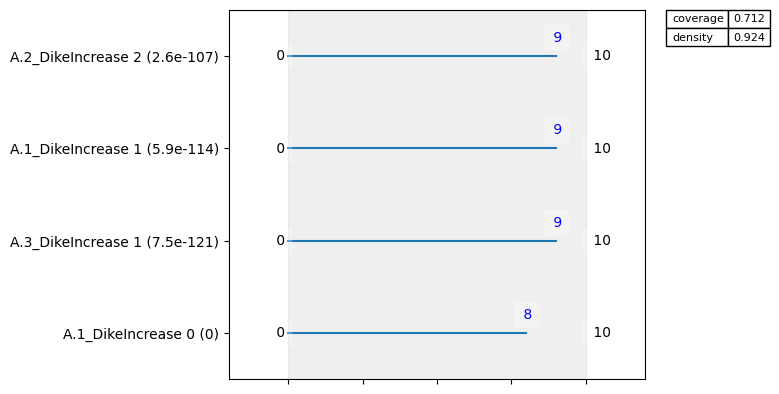

In [12]:
# Inspect box
box_dike_inv.inspect(5)
box_dike_inv.inspect(5, style='graph')
plt.show()

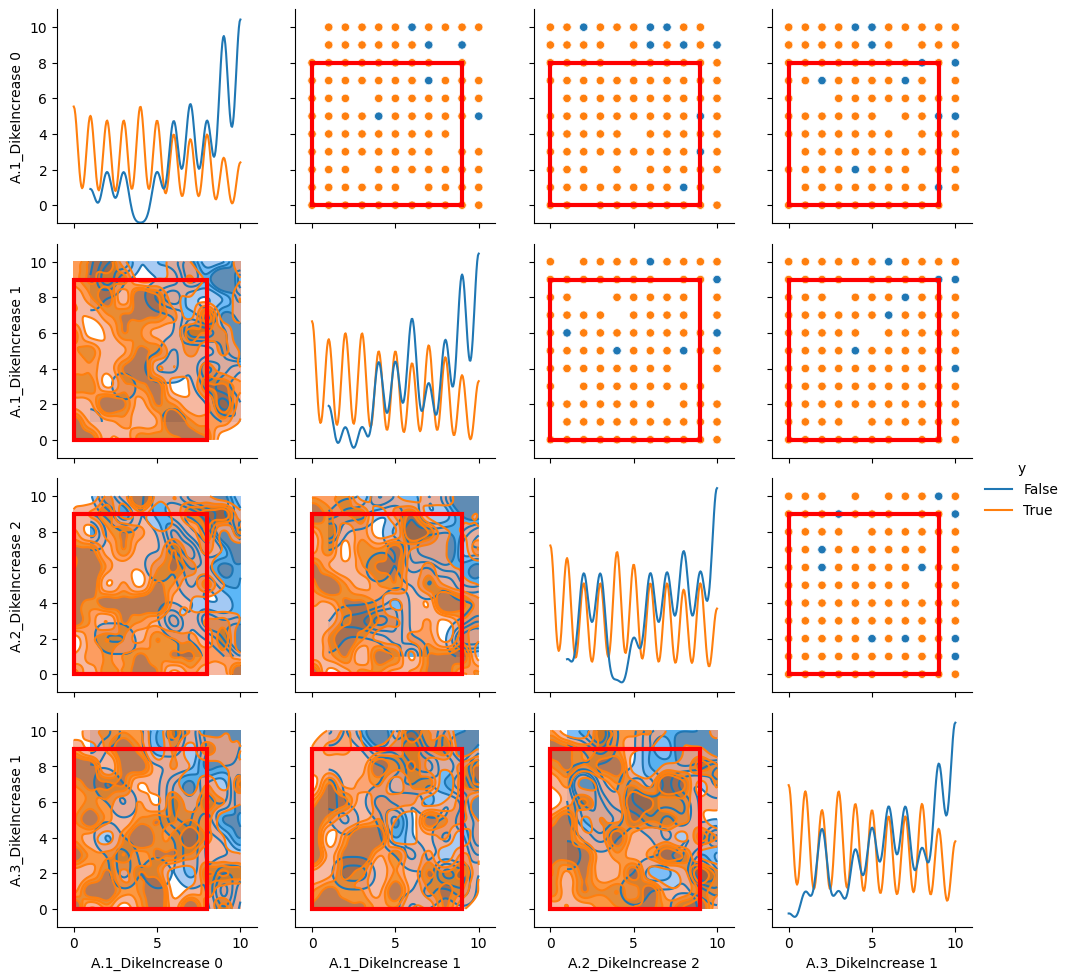

In [13]:
# Show scenario discovery
box_dike_inv.show_pairs_scatter(5)
plt.show()

# 2. Visualize the results using Dimensional Stacking


In [14]:
from ema_workbench.analysis import dimensional_stacking

### 1. Dimensional stacking voor 'RfR Total Costs

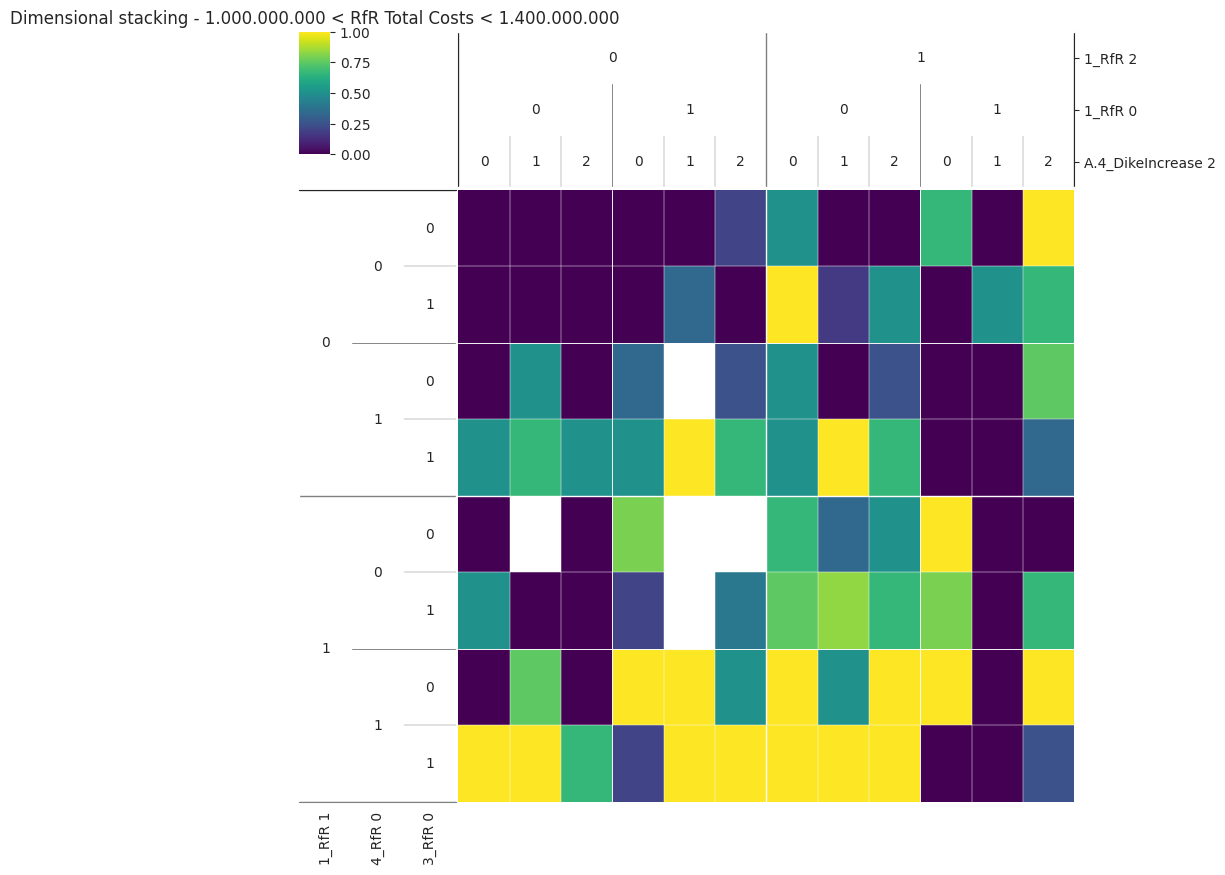

In [15]:
# Create a dimensional stacking plot for scenarios where RfR Total Costs fall within the specified range
dimensional_stacking.create_pivot_plot(experiments, y_rfr)
plt.title("Dimensional stacking - 1.000.000.000 < RfR Total Costs < 1.400.000.000")
plt.show()

### 2. Dimensional stacking voor 'Expected Annual Damage'


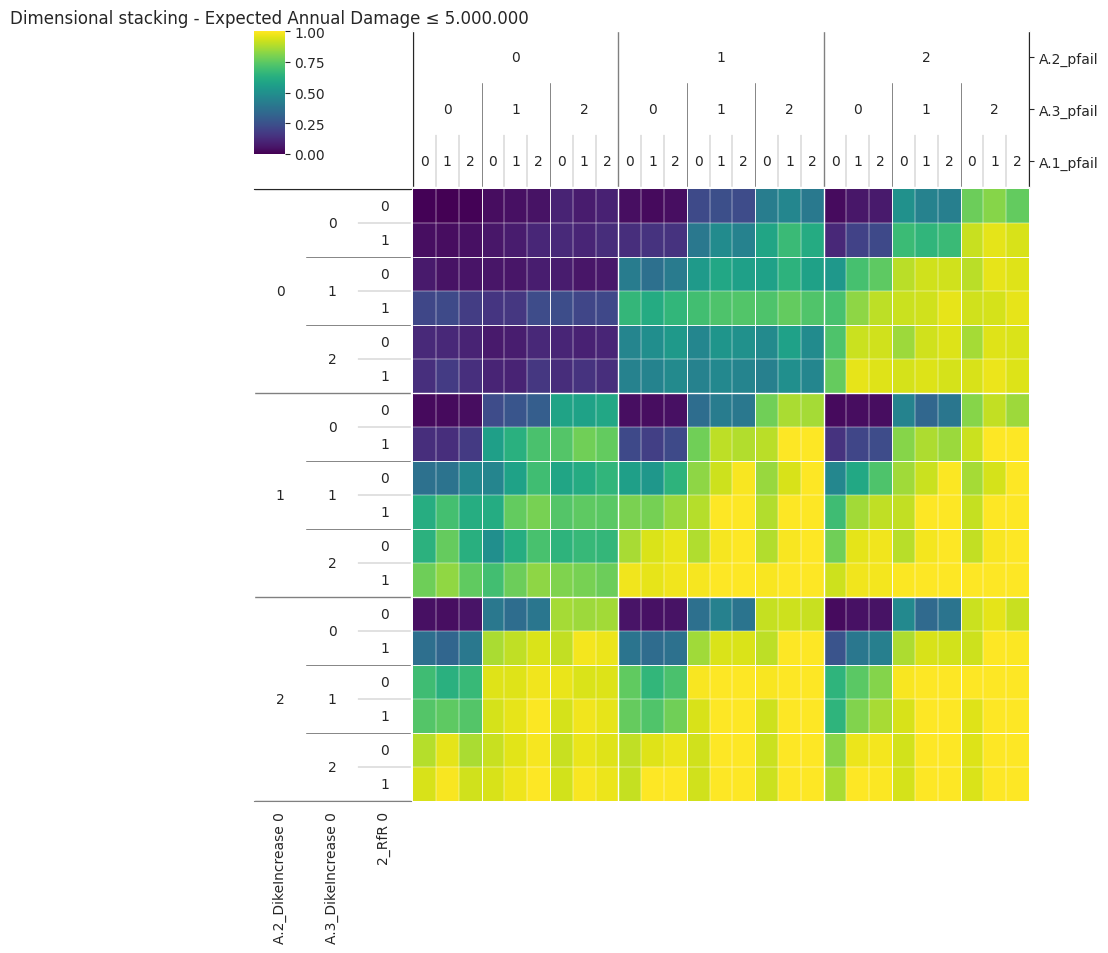

In [16]:
# Create a dimensional stacking plot for scenarios where Expected Annual Damage fall within the specified range
dimensional_stacking.create_pivot_plot(experiments, y_ead)
plt.title("Dimensional stacking - Expected Annual Damage ≤ 5.000.000")
plt.show()

### 3. Dimensional stacking voor 'Dike Investment Costs'

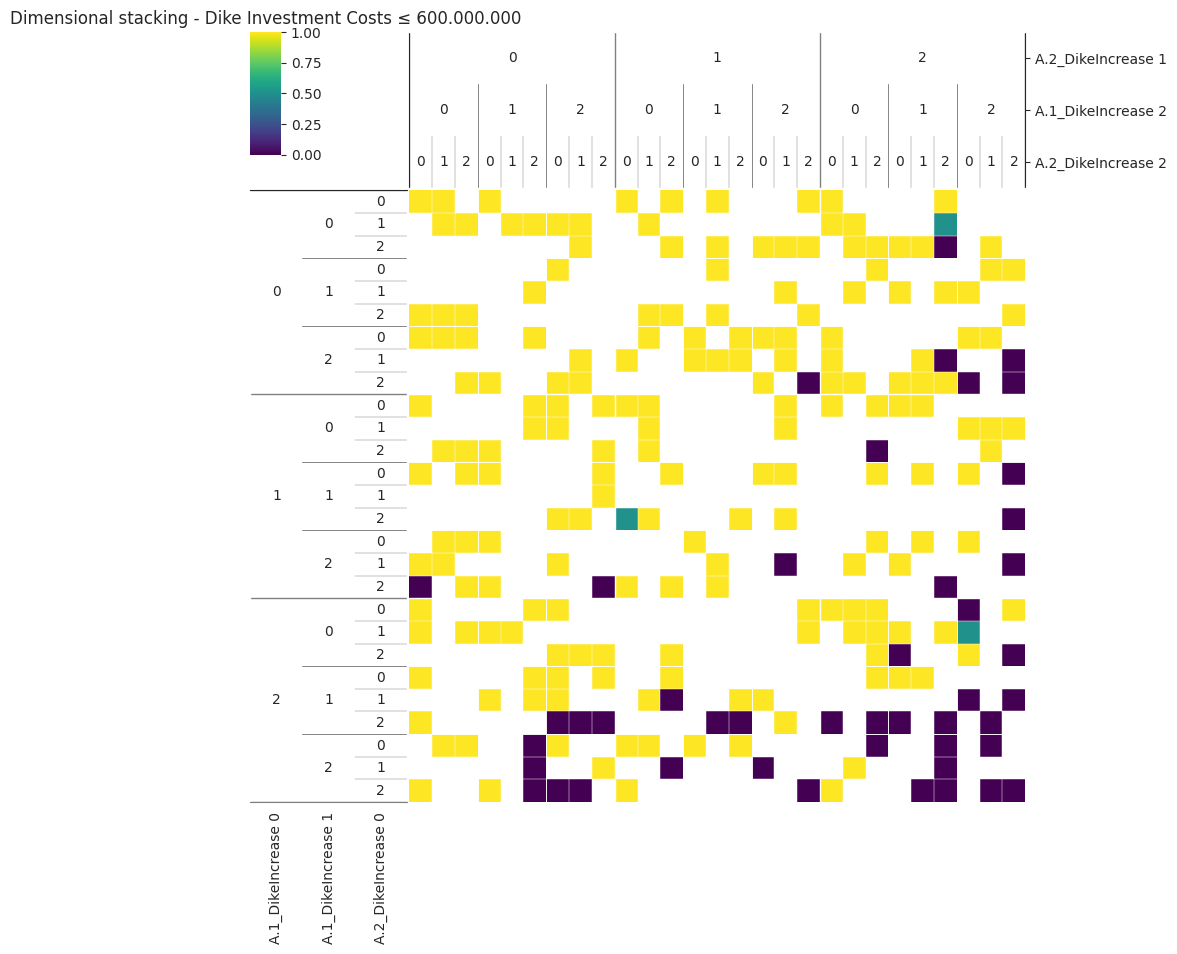

In [17]:
# Create a dimensional stacking plot for scenarios where Dike Investment Costs fall within the specified range
dimensional_stacking.create_pivot_plot(experiments, y_dike_inv)
plt.title("Dimensional stacking - Dike Investment Costs ≤ 600.000.000")
plt.show()